# Load libraries and data

In [124]:
import sys
import os
from os import path
from datetime import date
import math
import warnings
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from plotnine import *
from scipy import stats
from scipy.stats import linregress
import gspread
from mizani.formatters import scientific_format
from mizani.breaks import date_breaks
from mizani.formatters import date_format
import warnings

%matplotlib inline

import skmisc
import outliers
from outliers import smirnov_grubbs as grubbs

# read in custom modules
sys.path.append('/Users/rosekantor/work/wbe_data_analysis/')

from read_gsheets import * 
from reprocess_qpcr import *
from calculations import *
from qa_qc import *
from quality_score import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [125]:
sites = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/site_lookup_120820.csv'
samples = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/sample_inventory_120820.csv'
qpcr = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/QuantStudio_raw_data_120820.csv'
plates = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/Plate_info_120820.csv'

In [126]:
gc = None
url = None
rxn_volume = 20.0
template_volume = 5.0

plate_df = read_qpcr_data(gc, url, qpcr)
plate_df = plate_df[plate_df.plate_id >= 1000]
qpcr_processed_dilutions, plate_target_info = process_qpcr_plate(plate_df)


# merge plate data with data coming out of process_qpcr_plate
plate_info_df = pd.read_csv(plates)
plate_target_info = plate_target_info.merge(plate_info_df, how = 'left', on = 'plate_id')

# fill in default values
plate_target_info.loc[plate_target_info.rxn_volume.isna(), 'rxn_volume'] = rxn_volume
plate_target_info.loc[plate_target_info.template_volume.isna(), 'template_volume'] = template_volume

# process Xeno assay results to check for inhibition
qpcr_processed_dilutions_xeno = qpcr_processed_dilutions[qpcr_processed_dilutions.Target == 'Xeno']
df_xeno = []
for plate_id, df in qpcr_processed_dilutions_xeno.groupby('plate_id'):
    df_inhibition = process_xeno_inhibition(df, plate_target_info, plate_id)
    df_xeno.append(df_inhibition)
df_xeno = pd.concat(df_xeno)
qpcr_processed_dilutions = qpcr_processed_dilutions.merge(df_xeno, how='left', on=['Sample', 'dilution', 'plate_id'])
qpcr_processed_dilutions = qpcr_processed_dilutions[qpcr_processed_dilutions.Target != 'Xeno']

/Users/rosekantor/work/wbe_data_analysis/reprocess_qpcr.py:304: UserWarning: Plate 1064 is missing NTC
/Users/rosekantor/work/wbe_data_analysis/reprocess_qpcr.py:304: UserWarning: Plate 1064 is missing NTC


# Find diluted samples and summarize

In [127]:
#qpcr_processed_dilutions = qpcr_processed_dilutions[qpcr_processed_dilutions.plate_id != 1052] #remove DNA vs RNA comparison

df = qpcr_processed_dilutions[qpcr_processed_dilutions.duplicated(['Sample', 'Target', 'dilution'], keep=False)]
df = df[~df.Sample.str.contains('control')] #remove controls
df = df[['Sample', 'plate_id', 'Target', 'dilution', 'Cq_mean', 'Quantity_mean', 'nondetect_count']]
df.Cq_mean = df.Cq_mean.round(3)
df.Quantity_mean = df.Quantity_mean.round(3)

In [128]:
df_summary = df.groupby(['Sample', 'Target', 'dilution']).agg(
                                                 plates_list=('plate_id', lambda x: x.tolist()),
                                                 Cq_min=('Cq_mean', 'min'),
                                                 Cq_max=('Cq_mean', 'max'),
                                                 Cq_list=('Cq_mean', lambda x: x.tolist()),
                                                 Quantity_min=('Quantity_mean', 'min'),
                                                 Quantity_max=('Quantity_mean', 'max'),
                                                 mean_of_quantites=('Quantity_mean', 'mean'),
                                                 Quantity_list=('Quantity_mean', lambda x: x.tolist()),
                                                 Cq_count=('Cq_mean', 'count')
                                                )
df_summary = df_summary.reset_index()
df_summary = df_summary[df_summary.Cq_count != 0]
df_summary['delta_Cq'] = df_summary.Cq_max - df_summary.Cq_min
df_summary['delta_quantity'] = df_summary.Quantity_max - df_summary.Quantity_min
df_summary['percent_change_of_quantity'] = 100 * df_summary.delta_quantity / df_summary.Quantity_min
df_summary.percent_change_of_quantity = df_summary.percent_change_of_quantity.round(2)

## Explanation:

These samples were run twice, mostly by accident.  We can use this to compare reproducibility across runs of the same samples on different plates, before/after freeze-thaw of the RNA. *Note that plates 1051 and 1052 are deliberately duplicated, and the quantites may be different because 1051 used an RNA standard curve, while 1052 used a DNA standard curve.*

In [129]:
df_summary

,Sample,Target,dilution,plates_list,Cq_min,Cq_max,Cq_list,Quantity_min,Quantity_max,mean_of_quantites,Quantity_list,Cq_count,delta_Cq,delta_quantity,percent_change_of_quantity
0,B_B_SQ_110720_2,N1,1,"[1064, 1070]",34.063,37.880,"[37.88, 34.063]",2.915,20.063,1.148900e+01,"[2.915, 20.063]",2,3.817,17.148,588.27
1,D_SEP_NF_101520_1,N1,1,"[1033, 1052]",37.259,38.718,"[37.259, 38.718]",0.273,6.693,3.483000e+00,"[6.693, 0.273]",2,1.459,6.420,2351.65
2,D_SEP_NF_101520_2,N1,1,"[1051, 1052]",36.794,36.794,"[nan, 36.794]",1.018,1.018,1.018000e+00,"[nan, 1.018]",1,0.000,0.000,0.00
3,D_SEP_NF_101520_3,N1,1,"[1051, 1052]",36.563,37.027,"[36.563, 37.027]",0.868,7.276,4.072000e+00,"[7.276, 0.868]",2,0.464,6.408,738.25
4,D_SEP_NF_102220_1,N1,1,"[1040, 1052]",34.642,35.451,"[34.642, 35.451]",2.553,9.332,5.942500e+00,"[9.332, 2.553]",2,0.809,6.779,265.53
5,D_SEP_NF_102220_2,N1,1,"[1051, 1052]",34.474,35.344,"[35.344, 34.474]",4.984,15.127,1.005550e+01,"[15.127, 4.984]",2,0.870,10.143,203.51
6,D_SEP_NF_102220_3,N1,1,"[1051, 1052]",34.266,35.162,"[34.266, 35.162]",3.111,28.892,1.600150e+01,"[28.892, 3.111]",2,0.896,25.781,828.70
7,D_SEP_NF_102220_4,N1,1,"[1051, 1052]",34.287,34.450,"[34.45, 34.287]",5.664,25.861,1.576250e+01,"[25.861, 5.664]",2,0.163,20.197,356.59
8,D_SEP_NF_102920_1,N1,1,"[1051, 1052]",32.995,33.217,"[33.217, 32.995]",13.720,54.227,3.397350e+01,"[54.227, 13.72]",2,0.222,40.507,295.24
9,D_SEP_NF_102920_2,N1,1,"[1051, 1052]",33.083,33.780,"[33.083, 33.78]",8.014,58.781,3.339750e+01,"[58.781, 8.014]",2,0.697,50.767,633.48


# Plots

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 10'. Pick better value with 'binwidth'.


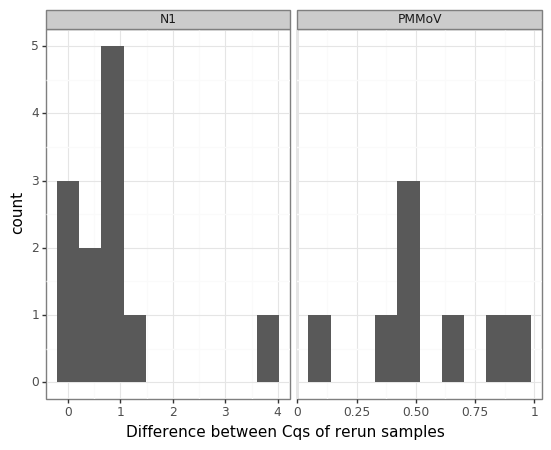

<ggplot: (298447765)>

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 7'. Pick better value with 'binwidth'.


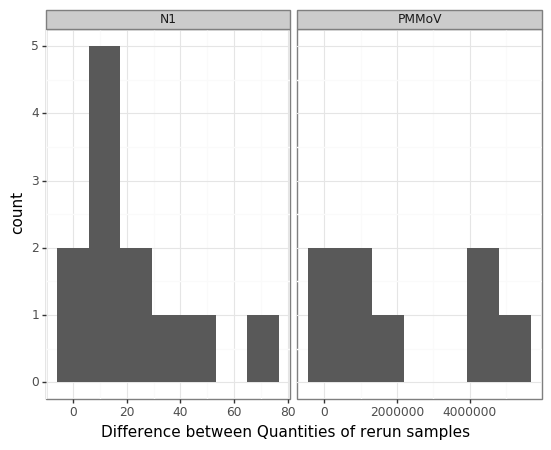

<ggplot: (299084413)>

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 3'. Pick better value with 'binwidth'.


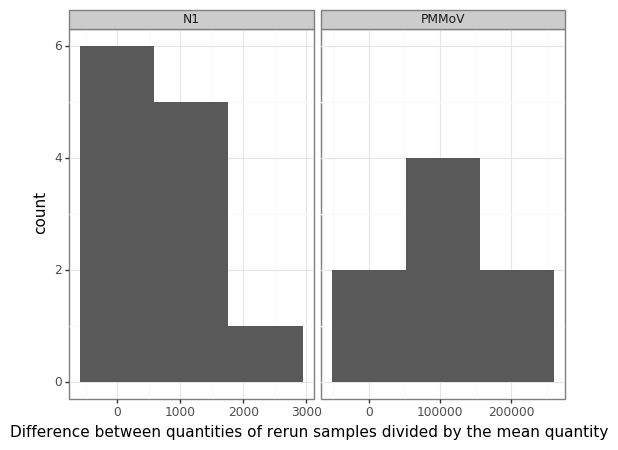

<ggplot: (299170949)>

In [130]:
plt1 = (ggplot(df_summary, aes(x='delta_Cq'))+
 geom_histogram()+
 theme_bw()+
 xlab('Difference between Cqs of rerun samples')+
 facet_grid('~ Target', scales='free_x'))

display(plt1)

plt2 = (ggplot(df_summary, aes(x='delta_quantity'))+
 geom_histogram()+
 theme_bw()+
 xlab('Difference between Quantities of rerun samples')+
 facet_grid('~ Target', scales='free_x'))

display(plt2)

plt3 = (ggplot(df_summary, aes(x='percent_change_of_quantity'))+
 geom_histogram()+
 theme_bw()+
 xlab('Difference between quantities of rerun samples divided by the mean quantity')+
 facet_grid('~ Target', scales='free_x'))

display(plt3)